# OFFLINE ANALYSIS FOR PPG PROCESSING AND SPO2 HR COMPUTATION #

## Simulation Design Philosophy

This notebook is part of a **simulation-driven validation workflow** for the
embedded PPG signal processing firmware.

### Simulation Entry Point

The simulation is started by running the following script:

- simulation/wait_measure_trigger.py


This script implements a **host-based PPG signal generator** that emulates
an external ADC device.  
The simulation is **MCU-driven**: samples are transmitted only upon explicit
request from the embedded firmware.

---

### Key Design Principles

- The **MCU is the timing master**
- Python acts as a **virtual ADC / signal source**
- Samples are sent **only when requested by the MCU**
- Inter-window settling time simulates sensor stabilization
- The same embedded processing pipeline is used in:
  - simulation mode
  - real hardware acquisition

This approach allows validation of **RTOS behavior, task scheduling, and data
flow**, independently from sensor availability.

---

### Signal Capture and Offline Analysis

The data analyzed in this notebook is **not generated by Python**.

Instead, it is captured directly from the embedded system using
**SEGGER J-Scope**, plotting and exporting the following global variables:

- `adc_raw`  
- `filtered_signal`

The signals are:
1. Plotted in real time using J-Scope
2. Exported as `.csv` files
3. Imported into this notebook for offline analysis and visualization

This ensures that all offline analysis is performed on **real embedded data**
produced by the firmware under realistic timing conditions.

---

### Timing Interpretation

- **Embedded timing correctness** must be evaluated using:
  - hardware timers
  - RTOS execution traces
  - J-Scope time base
- **Python wall-clock time** includes:
  - serial latency
  - OS scheduling jitter
  - interpreter overhead

For this reason, Python execution time is **not used** as a metric for
real-time performance and is expected to differ from embedded timing.

This behavior is intentional and reflects real-world system integration
constraints.


In [75]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
from scipy.signal import firwin, lfilter

## IMPORT CSV File ##

In [76]:
df = pd.read_csv('ppg_signal_emu.csv', sep = ';' )
filtered_signal = df['filtered_signal'].to_numpy()
time           = df['Timestamp'].to_numpy()
ppg_input       = df['adc_raw'].to_numpy()

In [77]:
fs_jscope = 1000   # Hz depends on JScope generated csv
fs_mcu    = 100    # Hz ADC Sampling

decim = fs_jscope // fs_mcu  


In [78]:
time = np.arange(len(filtered_signal)) / fs_jscope

## CUTTING SIGNAL ##

In [79]:
diff = np.abs(np.diff(filtered_signal))
threshold = np.mean(diff) * 3
active_idx = np.where(diff > threshold)[0]
start = active_idx[0]
end = active_idx[-1]

In [80]:
acquisition_time = (end-start)/1000
print(f'Time elapsed during simulation: {acquisition_time} s')

Time elapsed during simulation: 30.772 s


In [81]:
time_cut = time[start:end]
time_cut = time_cut - time_cut [0]
filtered_cut = filtered_signal[start:end]
adc_raw_cut = ppg_input[start:end]

### INPUT SIGNAL ###

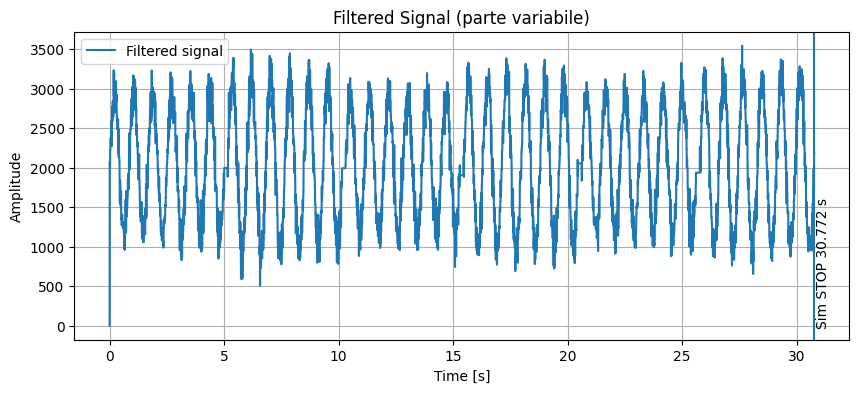

In [82]:
plt.figure(figsize=(10,4))
plt.plot(time_cut, adc_raw_cut, label="Filtered signal")
plt.xlabel("Time [s]")
plt.axvline(acquisition_time)
plt.text(acquisition_time + 0.1,0,f'Sim STOP {acquisition_time} s',rotation=90)
plt.ylabel("Amplitude")
plt.title("Filtered Signal (parte variabile)")
plt.grid(True)
plt.legend()
plt.show()

### Moving Average Filtered Signal ###

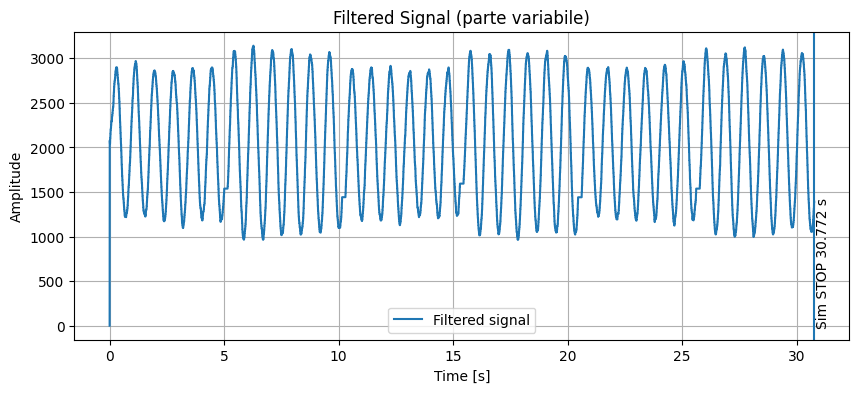

In [83]:
plt.figure(figsize=(10,4))
plt.plot(time_cut, filtered_cut, label="Filtered signal")
plt.xlabel("Time [s]")
plt.axvline(acquisition_time)
plt.text(acquisition_time + 0.1,0,f'Sim STOP {acquisition_time} s',rotation=90)
plt.ylabel("Amplitude")
plt.title("Filtered Signal (parte variabile)")
plt.grid(True)
plt.legend()
plt.show()
